# CA2 - Statistical Insights on Agriculture in Ireland and EU

## Overview

In this notebook, the following agriculture datasets were analysed, focusing on Ireland and other similar countries in the EU:

- Organic Farming Growth
- Agriculture Import/Export Balance
- Food Price Inflation

The datasets were studied and the following statistical techniques were applied:

- Confidence interval

- Hypoteshis tests:
    - Shapiro
    - Levene
    - Non-parametric tests:
        - Kruskal
        - Mannwhitneyu
        - Wilcoxon
    - Parametric test:
        - Anova One-Way

This notebook is divided into two parts (i) Confidence Interval and (ii) Hypothesis tests. 

In the first part, the Organic Farming dataset were used to find a confidence interval for the average area under organic farming in the EU.

In the second part, the Import/Export and Food Price Inflation datasets were checked against some inferential statistics tests.

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

In [305]:
#!pip install altair
#!pip install pingouin
from pingouin import kruskal
from scipy.stats import wilcoxon
from scipy.stats import levene
from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

def plotInteractiveTradeData(data, dropdown=[], y_label='', main_title=''):
    """
    This function uses altair lib to plot interactive graph based on the input.
    
    Parameters:
        data: Data frame
        dropdown: List of items to filter the data displayed in the graph
        y_label: Y label text
        main_title: Title of the graph
    """
    input_dropdown = alt.binding_select(options=dropdown, name='Item')

    select_item = alt.selection_single(
        name='Select Import Item', fields=['Item'], init={'Item': dropdown[0]},
        bind=input_dropdown)

    alt.Chart(data, title=main_title).mark_point(filled=True).encode(
        alt.X('Year', scale=alt.Scale(zero=False)),
        alt.Y('Value', scale=alt.Scale(zero=False), title=y_label),
        alt.Size('Value:Q'),
        alt.Color('Area:N'),
        alt.Order('Value:Q', sort='descending'),
        tooltip='Value:N'
    ).add_selection(select_item).transform_filter(select_item).display()

def convertColumnsToNumber(df, colsList=[]):
    """
    This function converts the column in the list into
    numeric data type.

    Parameters:
        df: Data frame with original data.
        colsList: List of column names to be converted.
    Return:
        Updated dataframe.
    """         
    for c in colsList:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df
    
def isDistNormal(data_col):
    """
    This function applies the Shapiro test to decide
    if the data is from a normal distribution or not.

    Parameters:
        data_col (data series): DataSeries
    Return:
        (bool): True if data is normal, false otherwise.
    """
    shapiro_test = stats.shapiro(data_col)
    if shapiro_test.pvalue > 0.05:
        return True
    return False
    
def plotColGraph(data_col, title=''):
    """
    This function plots a graph for the column specified
    in the input.

    Parameters:
        data_col (data series): DataSeries
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    stats.probplot(data_col, plot=ax)
    ax.set_title(title)

def removeEmptyRows(data, col):
    """
    This function removes empty rows from data frame based on the
    specified column.

    Parameters:
        data (pd.DataFrame): DataFrame
    Returns:
        data without empty
    """
    null_filter = data[col].notnull()
    return data[null_filter]

def getNonEmptyValues(col_data):
    """
    This function removes empty rows from data frame series (column).

    Parameters:
        col_data (pd.Series): DataFrame series
    Returns:
        Non empty rows
    """
    null_filter = col_data.notnull()
    return col_data[null_filter]

def confidenceIntervalTStudent(mean, std, n, alpha=.97):
    """
    This function calculates the confidence interval for the given paramters.
    
    Parameters:
        mean (num): Average of the sample
        std  (num): Standard deviation of the sample
        n    (int): Size of sample
    Returns:
        (num, num): (lower limit, upper limit)
    """
    t = abs(stats.t.ppf((1 - alpha)/2, n - 1))
    interval = t * std/sqrt(n - 1)
    return mean - interval, mean + interval

def getStatsArray(stats_dict, val='mean'):
    """
    This function extracts the stats from the dictionary into a numpy array.
    
    Parameters:
        stats_dict (dict): Dictionary with custom statistics
        val         (str): Measurement to return (must be one of [mean, std, count, ll, ul])
    Returns:
        np array with values as per parameter or empty if input is invalid.
    """
    if val not in ['mean', 'std', 'count', 'll', 'ul']:
        return np.array([])
    return np.array(list([stats_dict[year][val] for year in stats_dict]))

## Confidence Interval

For this study, the organic farming data from Eurostat portal were used.

In this analysis the sample data on the growth of organic farming in several European countries were used to obtain a confidence interval of the same growth in Europe (population) over the years.

The steps of this analysis were detailed in the section below.

### Organic Farming

Eurostat provides yearly data on the percent of UAA (utilized agricultural area) under organic farming per country in Europe.

Problem: What is the average percent of land of the total UAA that is occupied by organic farming in Europe as a whole? How does it compare to Ireland?

- Available data:

    * Percent of total UAA under organic farming by year by country in Europe.

- Approach:

    * Use countries data (samples) to find a confidence interval for the total UAA under organic farming in Europe (population) per year. 

    * Compare the growth rate of organic farming in Europe with Ireland.

### Data Preparation and Visualization

In this section, the dataset is cleand and prepared for the statistical analysis. 

The raw data was cleansed to remove unnecessary columns and to convert the percent data into numeric data type. 

This step was necessary to fit the dataset into the functions used to calculate the confidence interval.

It was created two data frames, one with the whole dataset and another one with Ireland's data only.

This step was done to compare Ireland's organic farming growht with the estimated confidence interval for Europe.

After that the data was checked for nulls. Null values can impact on the analysis, so they were removed from the dataset.

In [309]:
# showing raw dataset
dataset = pd.read_csv('./datasets/organic-farming.csv')
dataset.head()

,GEO (Codes),GEO (Labels),2000,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,EU,"European Union (EU6-1958, EU9-1973, EU10-1981,...",3.0,:,3.8,4.0,:,3.8,4.1,4.0,...,5.4,5.66,5.70,5.78,6.20,6.68,7.03,7.50,7.92,9.08
1,EU27_2020,European Union - 27 countries (from 2020),:,:,:,:,:,:,:,:,...,:,5.88,5.91,6.08,6.56,7.09,7.48,8.03,8.49,9.08
2,EU28,European Union - 28 countries (2013-2020),:,:,:,:,:,:,:,:,...,:,5.64,5.70,5.78,6.20,6.68,7.03,7.50,7.92,:
3,BE,Belgium,1.5,1.6,2.1,1.7,1.7,1.7,2.1,2.4,...,4.1,4.48,4.67,5.00,5.17,5.80,6.28,6.56,6.85,7.25
4,BG,Bulgaria,:,:,:,:,:,0.2,0.1,0.3,...,0.5,0.76,1.13,0.96,2.37,3.20,2.72,2.56,2.34,2.30


In [310]:
# keeping only countries data
codesCol = dataset.keys()[0]
dataset = dataset.loc[~dataset[codesCol].str.contains('EU')]

# getting Ireland's data only
dataset_ire = dataset.loc[dataset[codesCol] =='IE']

# removing first two columns with labels
dataset = dataset.iloc[:,2:]
dataset_ire = dataset_ire.iloc[:,2:]

# converting data into numbers
columns = dataset.keys()
convertColumnsToNumber(dataset, columns)
convertColumnsToNumber(dataset_ire, columns)   

dataset.describe()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,16.000000,16.000000,17.000000,20.000000,26.000000,29.000000,28.000000,28.000000,28.000000,28.000000,...,27.000000,30.000000,33.000000,33.000000,34.000000,33.000000,34.000000,33.000000,34.000000,33.000000
mean,3.537500,3.968750,4.211765,4.380000,4.111538,4.475862,4.667857,4.850000,5.182143,5.592857,...,6.311111,6.631000,6.146970,6.339394,6.532059,7.208788,7.424706,8.031212,8.236176,8.639091
std,3.523043,3.561782,3.463720,3.452017,3.380808,3.624781,3.687120,3.651129,3.824681,4.178865,...,4.816744,4.676364,4.862754,5.001229,5.175618,5.529636,5.996805,6.265392,6.544499,6.679408
min,0.600000,0.700000,0.700000,0.200000,0.000000,0.100000,0.100000,0.300000,0.300000,0.200000,...,0.200000,0.320000,0.060000,0.270000,0.170000,0.210000,0.250000,0.350000,0.290000,0.290000
25%,1.200000,1.600000,2.100000,2.150000,1.725000,1.900000,2.000000,1.875000,2.075000,2.550000,...,2.850000,3.200000,2.650000,2.670000,2.490000,3.200000,2.965000,3.330000,3.017500,3.520000
50%,1.800000,2.300000,2.600000,3.450000,3.400000,4.200000,4.000000,4.600000,5.200000,5.150000,...,5.400000,5.540000,5.230000,5.050000,5.055000,6.050000,6.370000,6.940000,7.455000,8.000000
75%,5.900000,6.375000,6.500000,6.550000,6.250000,6.800000,7.200000,6.700000,7.350000,7.650000,...,8.300000,8.920000,8.180000,9.290000,9.315000,9.750000,9.825000,10.010000,10.905000,11.670000
max,13.800000,14.000000,14.500000,15.400000,16.000000,16.700000,16.700000,17.000000,17.400000,18.500000,...,19.600000,18.620000,18.400000,19.350000,20.300000,21.250000,23.370000,24.080000,25.330000,25.690000


In [311]:
# checking empty values on full dataset
dataset.isnull().sum()

2000    18
2001    18
2002    17
2003    14
2004     8
2005     5
2006     6
2007     6
2008     6
2009     6
2010     7
2011     7
2012     4
2013     1
2014     1
2015     0
2016     1
2017     0
2018     1
2019     0
2020     1
dtype: int64

In [312]:
# checking empty values on ireland dataset
dataset_ire.isnull().sum()

2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
dtype: int64

### Analysis

For each year (column) it was calculated the standard deviation and average of the percent of land under organic farming in all European countries in the dataset.

This way, it was possible to calculate the confidence interval of the population (Europe) per year.

For each year, it was stored the standard deviation, mean, lower and upper limit obtained from the confidence interval calculation.

In [313]:
# calculate descriptive stats (standard deviation and average) of the sample data - without nulls
stats_dict = {}
for c in columns:
    dataset_c = getNonEmptyValues(dataset[c])
    desc_stats = dataset_c.describe()
    stats_dict[c] = {'std': desc_stats.loc['std'], 'mean': desc_stats.loc['mean'], 'count': desc_stats.loc['count']}
    stats_dict[c]['ll'], stats_dict[c]['ul'] = confidenceIntervalTStudent(desc_stats.loc['mean'], desc_stats.loc['std'],  desc_stats.loc['count'])
#stats_dict

### Results

In this section, the results of the confidence interval obtained in the previous step were plotted into a graph.

This way, it's possible to observe how the size of organic farming has grown in Ireland as compared to Europe, using the confidence interval calculated from the sample data.

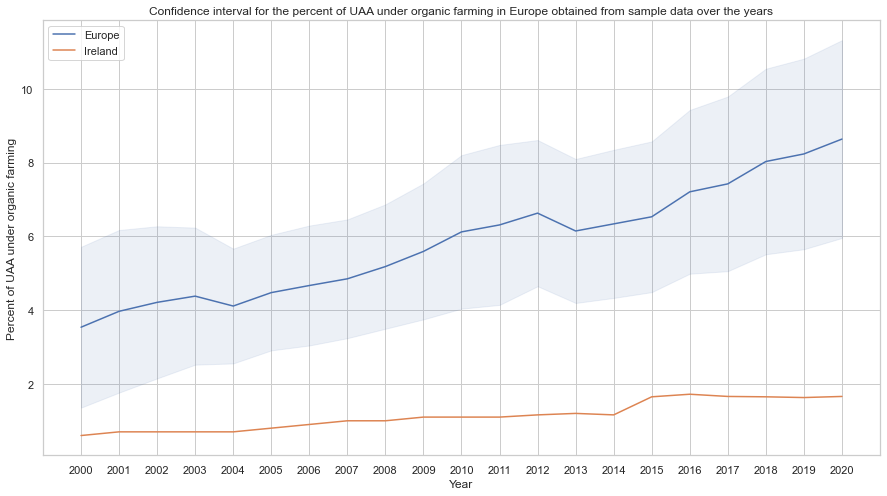

In [314]:
# get x data
x = np.array(list(stats_dict.keys()))

# get y data
y = getStatsArray(stats_dict, 'mean')

# get ll data
ll = getStatsArray(stats_dict, 'll')

# get ul data
ul = getStatsArray(stats_dict, 'ul')

# get ireland's data only
ire = dataset_ire.to_numpy().reshape(x.shape[0],)

# plot graph with europe and irelands data
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(x, y, label='Europe')
ax.set_title('Confidence interval for the percent of UAA under organic farming in Europe obtained from sample data over the years')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of UAA under organic farming')
ax.fill_between(x, ll, ul, color='b', alpha=.1)
ax.plot(x, ire, label='Ireland')
plt.legend(loc=2)

Based on the confidence interval calculated it is possible to say that in 2020, for instance, the percent of UAA under organic farming in Europe was between 5.95% and 11.32%.

This interval is accurate, because according to the <a href="https://agridata.ec.europa.eu/extensions/CountryFactsheets/CountryFactsheets.html?memberstate=Ireland#">Agridata</a>, in 2020, the percent of land under organic farming in Europe was about 9%.

## Hypothesis Tests

In this section, two datasets were analyzed using hypotesis tests in order to compare their populations mean and variance.

### Agriculture Import/Export Trade

FAO provides data on the import/export of crops and livestocks products from several countries with data ranging from 1961 up to 2020.

Finland, Slovakia and Ireland have about the same population according to the Word Population Review website, so it is roughly assumed they are similar countries.

In this study, the data about the import and export of agricultural goods from these countries are compared using inferential statistics tests.

#### Data Preparation and Visualization

In this step, the data is prepared to be processed using inferential statistics tests.

The first step was to convert the data in the Value's column into numeric data type to comply with the Python functions.

Also, the data was split into import/export quantity (data in tonnes) and import/export value (data in US$) datasets to facilitate data manipulation.

After splitting the datasets, it was checked the Unit column so that data is compared against the same measurement unit.

The last steps were to visualize the data in two ways: (i) import/export data summarized by year per country and (ii) top 10 imported products values and quantity in Ireland compared with other countries.

The reason to plot these graphs were to have a better idea about the behaviour of the data that can help to explain the inferential tests results.

In [315]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-import-export-eu.csv', encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


In [316]:
# checking empty values on full dataset
dataset.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64

In [317]:
# converting Value column into numeric data type
dataset = convertColumnsToNumber(dataset, ['Value'])
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


In [318]:
# checking the Element values
list(dataset['Element'].unique())

['Import Quantity', 'Import Value', 'Export Quantity', 'Export Value']

In [319]:
# splitting data into import/export value and quantity
im_ex_val_data = dataset[(dataset['Element'].isin(['Import Value', 'Export Value']))]
im_ex_qtt_data = dataset[(dataset['Element'].isin(['Import Quantity', 'Export Quantity']))]

In [320]:
# checking unit for import/export quantity data
print(im_ex_val_data['Unit'].unique())
print(im_ex_qtt_data['Unit'].unique())

['1000 US$']
['tonnes' 'Head' 'No' '1000 Head']


Import/Export value is measured in 1000 US$, so no need to change anything here. On the other hand, the Import/Export quantity data were collected using different units: ['tonnes' 'Head' 'No' '1000 Head'].

Most of the rows in the dataset is measured in Tonnes, so the other units were removed to avoid mixing up unrelated data.

In [321]:
im_ex_qtt_data['Unit'].describe()

count      97496
unique         4
top       tonnes
freq       94961
Name: Unit, dtype: object

In [322]:
# since tonnes is the most frequent unit, remove the other ones
im_ex_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Unit'] == 'tonnes']
im_ex_qtt_data.shape

(94961, 14)

The graph below shows the summarized (average) import/export values and quantities per country by year. This way, it is possible to visualize the differences between the countries.

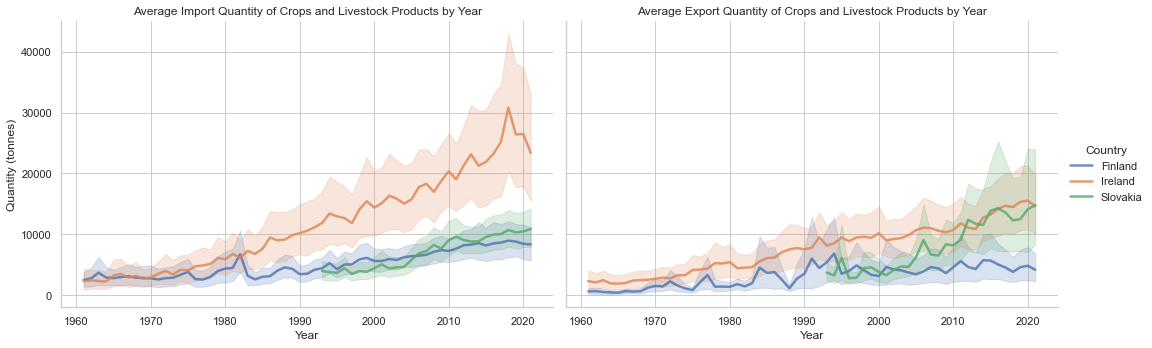

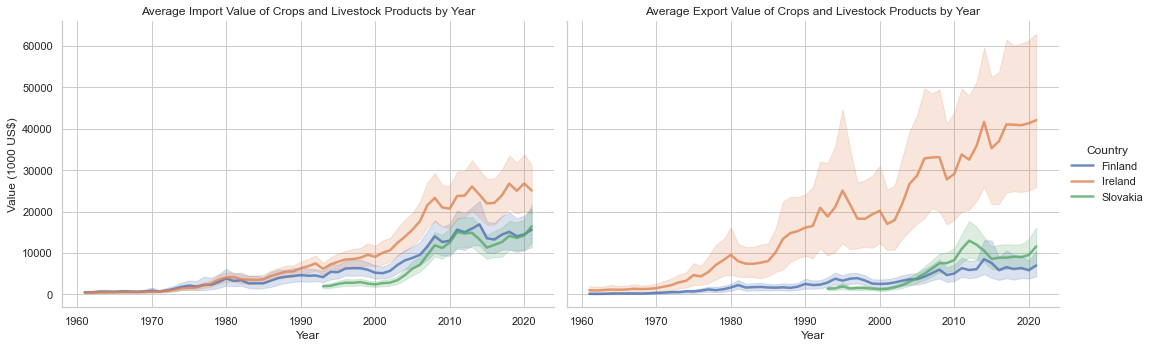

In [323]:
# adding the datasets into a list to facilitate graph generation
datasets = [im_ex_qtt_data, im_ex_val_data]

# y labels to be displayed
y_labels = ['Quantity (tonnes)', 'Value (1000 US$)']

# counter to access the arrays
idx = 0

# create the graph for each dataset (quantity and value)
for data in datasets:
    # create the grid to display the import and export data
    im_exp_grid = sns.FacetGrid(data, col='Element', hue='Area', height=5, aspect=1.5)

    # map the above form facetgrid with some attributes
    im_exp_grid.map(sns.lineplot, "Year", "Value", alpha=.8, linewidth=2.5)

    # adding legend
    im_exp_grid.add_legend(title='Country')
    
    # setting labels and titles
    im_exp_grid.set_xlabels('Year')
    im_exp_grid.set_ylabels(y_labels[idx])
    im_exp_grid.set_titles('Average {col_name} of Crops and Livestock Products by Year')
    idx+=1

Slovakia data covers a period of time between 1993 and 2020. Finland and Ireland have data starting from 1961.

According to the graphs, Ireland's import and export numbers are higher than the other countries, mainly in terms of export values in US$ (Graph 4), as compared to the other countries.

Regarding Slovakia and Finland, they import about the same quantity and values, having slighlty different behaviour with regards to the export numbers, where Slovakia shows more exports than Finland. 

In [325]:
# date range for Slovakia dataset
im_ex_qtt_data[im_ex_qtt_data['Area']=='Slovakia'].Year.sort_values().unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

The next interactive graphs show the import data per item for each country. This way, it is possible to compare the countries in a more granular level.

For this analysis, only the top 10 most imported items (in terms of quantity) into Ireland are displayed. 

The reason for limitting the data was due to a limitation in the Altair lib that can't handle more than 5k rows. It was also to facilitate data reading.

In [327]:
# getting import data only (quantity and value)
import_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity']
import_val_data = im_ex_val_data[im_ex_val_data['Element'] == 'Import Value']

# getting the top 10 import items in terms of quantity in Ireland
top_10_items_ire = import_qtt_data[(import_qtt_data['Area'] == 'Ireland')].groupby(by='Item', as_index=False).mean().sort_values(by=['Value'], ascending=False, ignore_index=True).head(10)
top_10_items_ire = list(top_10_items_ire['Item'].unique())

print('Top 10 most imported products in Ireland:')
top_10_items_ire

Top 10 most imported products in Ireland:


['Maize (corn)',
 'Wheat',
 'Cake of  soya beans',
 'Food wastes',
 'Molasses',
 'Raw milk of cattle',
 'Brewing or distilling dregs and waste',
 'Other non-alcoholic caloric beverages',
 'Bran of wheat',
 'Gluten feed and meal']

In [328]:
# getting the quantity data on the top 10 items
top_10_items_data_qtt = import_qtt_data[import_qtt_data['Item'].isin(top_10_items_ire)]
top_10_items_data_qtt.sort_values(by=['Value'], ascending=False, ignore_index=True)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2018,2018,tonnes,1601643.39,A,Official figure
1,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2019,2019,tonnes,1539355.99,A,Official figure
2,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2020,2020,tonnes,1313413.75,A,Official figure
3,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2021,2021,tonnes,1219959.29,A,Official figure
4,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,0112,Maize (corn),2017,2017,tonnes,1119412.15,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,39160,Brewing or distilling dregs and waste,2002,2002,tonnes,0.00,E,Estimated value
1506,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,39160,Brewing or distilling dregs and waste,2001,2001,tonnes,0.00,A,Official figure
1507,TCL,Crops and livestock products,372,Ireland,5610,Import Quantity,39160,Brewing or distilling dregs and waste,1972,1972,tonnes,0.00,A,Official figure
1508,TCL,Crops and livestock products,703,Slovakia,5610,Import Quantity,23540,Molasses,1996,1996,tonnes,0.00,T,Unofficial figure


In [329]:
# getting the value data on the top 10 items
top_10_items_data_val = import_val_data[import_val_data['Item'].isin(top_10_items_ire)]
top_10_items_data_val.sort_values(by=['Value'], ascending=False, ignore_index=True)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,372,Ireland,5622,Import Value,24490,Other non-alcoholic caloric beverages,2021,2021,1000 US$,340205.0,A,Official figure
1,TCL,Crops and livestock products,372,Ireland,5622,Import Value,24490,Other non-alcoholic caloric beverages,2008,2008,1000 US$,338670.0,A,Official figure
2,TCL,Crops and livestock products,372,Ireland,5622,Import Value,0112,Maize (corn),2021,2021,1000 US$,328511.0,A,Official figure
3,TCL,Crops and livestock products,372,Ireland,5622,Import Value,0112,Maize (corn),2018,2018,1000 US$,322647.0,A,Official figure
4,TCL,Crops and livestock products,372,Ireland,5622,Import Value,39170.01,Food wastes,2018,2018,1000 US$,320887.0,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1983,1983,1000 US$,0.0,A,Official figure
1506,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1982,1982,1000 US$,0.0,A,Official figure
1507,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1981,1981,1000 US$,0.0,A,Official figure
1508,TCL,Crops and livestock products,246,Finland,5622,Import Value,39160,Brewing or distilling dregs and waste,1980,1980,1000 US$,0.0,A,Official figure


In [330]:
# plotting an interactive graph with the quantity of the top import products
plotInteractiveTradeData(top_10_items_data_qtt, top_10_items_ire, 'Quantity (tonnes)', 'Top 10 most imported crops and livestock products in Ireland compared with other countries (Quantity in Tonnes)')

# plotting an interactive graph with the value of the top import products
plotInteractiveTradeData(top_10_items_data_val, top_10_items_ire, 'Value (1000 US$)', 'Top 10 most imported crops and livestock products in Ireland compared with other countries (Value in 1000 US$)')

alt.Chart(...)

alt.Chart(...)

#### Analysis

In this section the import/export data from each country are compared using inferential statistics tests in order to validate if their trade are similar.

The summarized import/export data are calculated for all countries. Comparisons with Slovakia should use data from 1993 until 2020 only due to Slovakia's lack of older data.

In [331]:
# getting the average quantity of tonnes of import/export a year
imp_ex_qtt_avg = im_ex_qtt_data.groupby(by=['Year', 'Element', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

# getting the average value in US$ of import/export a year
imp_ex_val_avg = im_ex_val_data.groupby(by=['Year', 'Element', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

##### Import/Export probability distributions - Shapiro Test

First it's necessary to check if the import/export data are normally distributted in order to decide which inferential test to apply.

From the distribution plotted below it was observed the data is not normally distributed. Using Shapiro test to confirm that hypotesis.

Is Export Quantity from Finland normally distributed? False
Is Import Quantity from Finland normally distributed? False
Is Export Quantity from Ireland normally distributed? False
Is Import Quantity from Ireland normally distributed? False
Is Export Quantity from Slovakia normally distributed? False
Is Import Quantity from Slovakia normally distributed? False


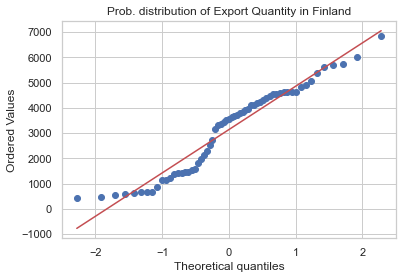

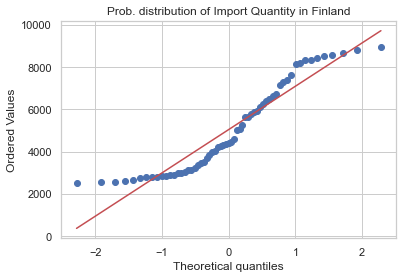

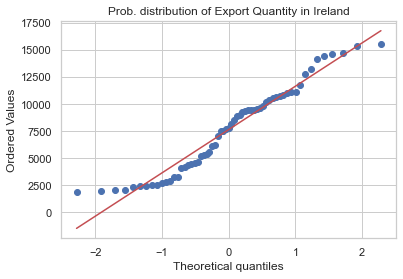

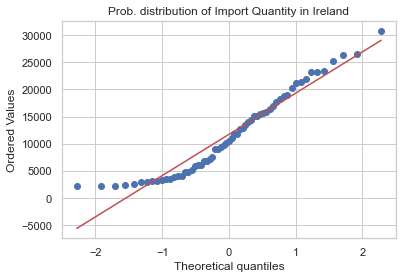

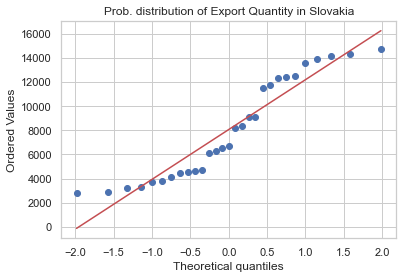

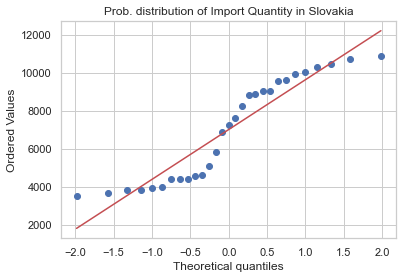

In [332]:
# checking import/export quantity average data are normal
for c in list(imp_ex_qtt_avg.Area.unique()):
    for e in list(imp_ex_qtt_avg.Element.unique()):
        data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Area'] == c)&(imp_ex_qtt_avg['Element'] == e)].Value
        plotColGraph(data, f'Prob. distribution of {e} in {c}')
        print(f'Is {e} from {c} normally distributed? {isDistNormal(data)}')

##### Import/Export between Slovakia and Finland - Kruskal Test

Since data is not normally distributed, Kruskal test will be applied to check if populations of both Finland and Slovakia are similar or not.

Since Slovakia data is being tested, it was used data 1993 until 2020, so both datasets are aligned.

In [333]:
# compare Slovakia and Finland import quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Import Quantity')&(imp_ex_qtt_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_qtt_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,0.065842,0.79749


In [334]:
# compare Slovakia and Finland import value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_val_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,3.688647,0.054784


In [335]:
# compare Slovakia and Finland export quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Export Quantity')&(imp_ex_qtt_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_qtt_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,9.243294,0.002364


In [235]:
# compare Slovakia and Finland export value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'].isin(['Slovakia', 'Finland']))&(imp_ex_val_avg['Year'] >= 1993)]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,0.322195,0.570291


Based on the results from the Kruskal test and assuming 5% significance level, it was possible to conclude that, apart from the export quantity, both Finland and Slovakia have the same average import/export of crops and livestock products.

This result can be verified by checking the graphs in the previous section, where it was observed that the curves are very similar between the two countries.

##### Import/Export between Ireland and Finland - Kruskal Test

The same test was applied to compare Ireland and Finland.

In [336]:
# compare Ireland and Finland import quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Import Quantity')&(imp_ex_qtt_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,23.987579,9.695921e-07


In [337]:
# compare Ireland and Finland import value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,1.904294,0.167598


In [338]:
# compare Ireland and Finland export quantity data
data = imp_ex_qtt_avg[(imp_ex_qtt_avg['Element'] == 'Export Quantity')&(imp_ex_qtt_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,37.975951,7.162206e-10


In [339]:
# compare Ireland and Finland export value data
data = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'].isin(['Ireland', 'Finland']))]
kruskal(data=data, dv='Value', between='Area')

,Source,ddof1,H,p-unc
Kruskal,Area,1,41.65836,1.086996e-10


Based on the results from the Kruskal test and assuming 5% significance level, it was possible to conclude that, apart from the import value, both Ireland and Finland have different import/export average.

This result can be verified by checking the graphs in the previous section, where it was observed that the curves are distant from each other in most of the cases, expect for the import value.

##### Import/Export between Ireland and Finland - Mann-Whitneyu Test

Using another non-parametric test to confirm results obtained from Kruskal. 

Validating the results when comparing Ireland and Finland trade data.

In [340]:
im_value_ire = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'] == 'Ireland')]
im_value_fin = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Import Value')&(imp_ex_val_avg['Area'] == 'Finland')]
stats.mannwhitneyu(im_value_ire['Value'], im_value_fin['Value'])

MannwhitneyuResult(statistic=2130.0, pvalue=0.16838818790437227)

In [246]:
im_value_ire = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'] == 'Ireland')]
ex_value_ire = imp_ex_val_avg[(imp_ex_val_avg['Element'] == 'Export Value')&(imp_ex_val_avg['Area'] == 'Finland')]
stats.mannwhitneyu(im_value_ire['Value'], ex_value_ire['Value'])

MannwhitneyuResult(statistic=3121.0, pvalue=1.1055235070125434e-10)

The above results confirm that, with 5% of significance level, Ireland and Finland are similar in the import value only, whereas in the other aspects there is enough evidence to confirm have different means.

#### Results

According to the tests above, Finland and Slovakia are similar countries with regards to import and export of agricultural products. They only differ in the quantity of goods that are exported from each country.

Ireland, on the other hand exports and import much more than the other two countries, which was confirmed by the inferential tests that showed the average of import/export between Ireland and Finland are substantially different.

### Food price inflation

FAO provides data on the food price inflation from several countries with data from 2001 up to 2022.

Finland, Slovakia and Ireland have about the same population according to the Word Population Review website.

In this study, the data about the food price inflation from these countries are compared using inferential statistics tests.

#### Data Preparation and Visualization

In this step, the data is cleansed for the inferential tests. The only operation was to remove an all-null column.

In [343]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-food-inflation-eu.csv', encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Year Code,Year,Item Code,Item,Months Code,Months,Unit,Value,Flag,Flag Description,Note
0,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7001,January,%,3.900862,E,Estimated value,NaN
1,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7002,February,%,2.525304,E,Estimated value,NaN
2,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7003,March,%,2.998384,E,Estimated value,NaN
3,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7004,April,%,2.810568,E,Estimated value,NaN
4,CP,Consumer Price Indices,246,Finland,2001,2001,23014,Food price inflation,7005,May,%,4.679704,E,Estimated value,NaN


In [344]:
# remove null column from dataset
dataset = dataset.drop(['Note'], axis=1)

In [345]:
# showing a summary of the dataset
dataset.describe()

,Area Code (M49),Year Code,Year,Item Code,Months Code,Value
count,783.000000,783.000000,783.000000,783.0,783.000000,783.000000
mean,440.333333,2011.379310,2011.379310,23014.0,7006.448276,1.793597
std,192.848091,6.283411,6.283411,0.0,3.438844,3.791925
min,246.000000,2001.000000,2001.000000,23014.0,7001.000000,-8.216785
25%,246.000000,2006.000000,2006.000000,23014.0,7003.000000,-0.764112
50%,372.000000,2011.000000,2011.000000,23014.0,7006.000000,1.376673
75%,703.000000,2017.000000,2017.000000,23014.0,7009.000000,4.179901
max,703.000000,2022.000000,2022.000000,23014.0,7012.000000,23.280147


The graph below shows the summarized food price inflation per country by year. This way, it is possible to visualize the differences between the countries over the years.

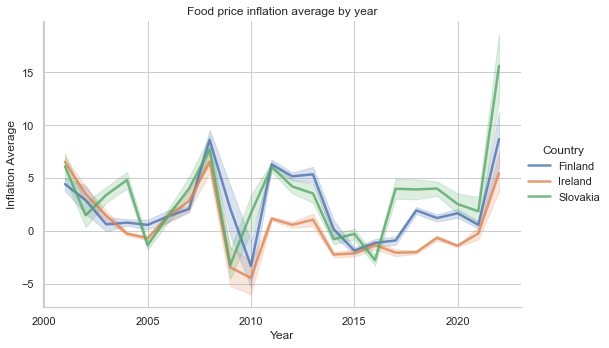

In [346]:
# create the grid to display the import and export data
food_inf = sns.FacetGrid(dataset, col='Item', hue='Area', height=5, aspect=1.5)

# map the above form facetgrid with some attributes
food_inf.map(sns.lineplot, "Year", "Value", alpha=.8, linewidth=2.5)

# adding legend
food_inf.add_legend(title='Country')

# setting labels and titles
food_inf.set_xlabels('Year')
food_inf.set_ylabels('Inflation Average')
food_inf.set_titles('{col_name} average by year')

According to the graph, Slovakia presents the highest food inflation among the three countries, whereas Ireland has the lowest numbers.

#### Analysis

In this section the food price inflation data from each country are compared using inferential statistics tests in order to validate if their average inflation are similar.

The summarized inflation data was calculated per country by year in the command below.

In [347]:
# group inflation by year to get consolidated data
food_inf_avg = dataset.groupby(by=['Year', 'Area'], as_index=False).mean().sort_values(by=['Year'], ignore_index=True)

##### Food price inflation probability distributions - Shapiro Test

First it's necessary to check if the summarized inflation data are normally distributted in order to decide which inferential test to apply.

From the distribution plotted below it was observed the data is normally distributed for Finland and Ireland only. Using Shapiro test to confirm that hypotesis.

Is food price inflation from Finland normally distributed? True
Is food price inflation from Ireland normally distributed? True
Is food price inflation from Slovakia normally distributed? False


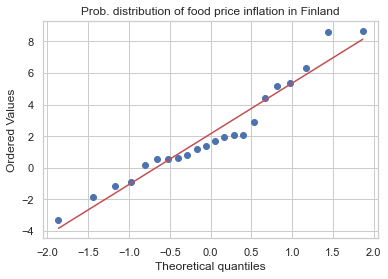

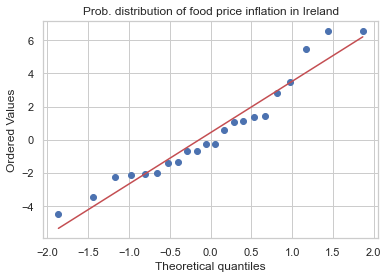

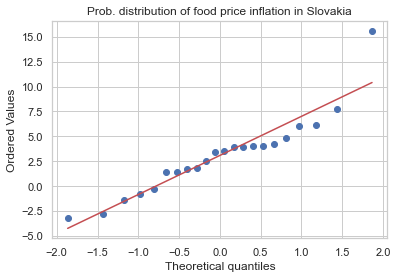

In [348]:
# checking food price inflation data are normal
for c in list(food_inf_avg.Area.unique()):
    data = food_inf_avg[food_inf_avg['Area'] == c].Value
    plotColGraph(data, f'Prob. distribution of food price inflation in {c}')
    print(f'Is food price inflation from {c} normally distributed? {isDistNormal(data)}')

##### Food price inflation between Ireland and Finland - Wilcoxon Test

Using non-parametric test to compare the aggregated food price inflation between Ireland and Finland.

In [275]:
# use wilcoxon stats test to compare inflation between Ireland and Finland
wilcoxon(food_inf_avg[food_inf_avg['Area'] == 'Ireland'].Value, food_inf_avg[food_inf_avg['Area'] == 'Finland'].Value)

WilcoxonResult(statistic=31.0, pvalue=0.0010914802551269531)

The result above shows that, with 5% of significance level, the average food price inflation are not similar between Ireland and Finland.

##### Food price inflation between Slovakia and Finland - Wilcoxon Test

Using non-parametric test to compare the aggregated food price inflation between Slovakia and Finland.

In [276]:
# use wilcoxon stats test to compare inflation between Finland and Slovakia
wilcoxon(food_inf_avg[food_inf_avg['Area'] == 'Slovakia'].Value, food_inf_avg[food_inf_avg['Area'] == 'Finland'].Value)

WilcoxonResult(statistic=82.0, pvalue=0.15597057342529297)

The result above shows that, with 5% of significance level, the average food price inflation are similar between Slovakia and Finland.

##### Food price inflation between the countries - Levene Test

Using Levene test to check if the food price inflation data between Ireland and the other countries have the same variance.

In [349]:
# comparing data between Ireland and Slovakia
levene(dataset[dataset['Area'] == 'Ireland'].Value, dataset[dataset['Area'] == 'Slovakia'].Value, center='mean')

LeveneResult(statistic=8.514924067703584, pvalue=0.0036748959348910956)

In [350]:
# comparing data between Ireland and Finland
levene(dataset[dataset['Area'] == 'Ireland'].Value, dataset[dataset['Area'] == 'Finland'].Value, center='mean')

LeveneResult(statistic=1.4196957338379543, pvalue=0.23399702504417083)

In [351]:
# comparing data between Finland and Slovakia
levene(dataset[dataset['Area'] == 'Finland'].Value, dataset[dataset['Area'] == 'Slovakia'].Value, center='mean')

LeveneResult(statistic=3.3359605800846253, pvalue=0.06835399267412658)

The above results suggest that, with 5% of significance level, there is no significant difference in the variance of the average food price inflation between Ireland and Finland and Finland and Slovakia. 

However, this result also suggests that, with 5% of significance level, Ireland and Slovakia food price inflation variance are different. 

These results confirm the first analysis of the graph in the Data Preparation and Visualization step.

##### Food price inflation between Finland and Ireland - Anova One Way Test

Using parametric test Anova with Ireland and Finland summarized food price inflation dataset as they met the normality requirement as per Shapiro test.

In [352]:
# using anova one way to compare Ireland and Finland
model = ols('Value~Area', data=food_inf_avg[food_inf_avg['Area'].isin(['Ireland', 'Finland'])]).fit()
aov = sm.stats.anova_lm(model, type=2)
print(aov)

            df      sum_sq    mean_sq         F    PR(>F)
Area       1.0   32.452641  32.452641  3.403211  0.072129
Residual  42.0  400.507295   9.535888       NaN       NaN


Based on the above result, with 5% of significance level, there is evidence to say that Ireland and Finland have similar food price inflation.

#### Results

By using different parametric and non-parametric inferential statistics tests it was possible to confirm and validate the food price inflation differences between the countries.

Ireland and Finland have similar inflation, while Ireland and Slovakia have significant differences.